# Find Articles linked to the question

### Imports and constants

In [1]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import time
import ast
import torch
from transformers import AutoTokenizer, AutoModel

In [2]:
PREV = "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers"

THERAPEUTIC_1 =  "Effectiveness of drugs being developed and tried to treat COVID-19 patients."
THERAPEUTIC_2 =  "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication."
THERAPEUTIC_3 = "Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents."

VACCINE_1 = "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients."
VACCINE_2 =  "Exploration of use of best animal models and their predictive value for a human vaccine."
VACCINE_3 =  "Efforts targeted at a universal coronavirus vaccine."
VACCINE_4 =  "Approaches to evaluate risk for enhanced disease after vaccination"
VACCINE_5 =  "Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"

DISTRIBUTION = "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need."

QUESTIONS = [PREV, THERAPEUTIC_1, THERAPEUTIC_2, THERAPEUTIC_3, 
             VACCINE_1, VACCINE_2, VACCINE_3, VACCINE_4, VACCINE_5, DISTRIBUTION]

In [3]:
FILE_NAME = '../data/metadata_with_ner_19_04.csv'

### Helping functions

In [4]:
def transform_vectors_mean(corpus, model, size):
    result = []

    for sent in corpus:
        s = []
        for w in sent:
            try:
                s.append(model[w])
            except KeyError:
                s.append(np.zeros(size))

        result.append(np.mean(s, axis=0))

    return result

def get_embeddings_hf(text, model):
    input_ids = torch.tensor(tokenizer.encode(text, max_length=512)).unsqueeze(0)  # Batch size 1
    # 512 max lenght for certain model
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    sentence_embedding = torch.mean(last_hidden_states[0], dim=0)
    
    return sentence_embedding.tolist()

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

### Read data

In [5]:
df = pd.read_csv(FILE_NAME)

In [6]:
len(df)

42998

In [7]:
df.columns

Index(['Unnamed: 0', 'cord_uid', 'title', 'license', 'abstract',
       'publish_time', 'authors', 'journal', 'url', 'disease_on_abstract',
       'chemicals_on_abstract'],
      dtype='object')

In [8]:
df = df[['cord_uid', 'title', 'license', 'abstract',
       'publish_time', 'authors', 'journal', 'url', 'disease_on_abstract',
       'chemicals_on_abstract']]

### Data Cleaning

In [9]:
# Remove NaN
df = df.dropna(subset=['abstract', 'title']).reset_index(drop=True)

# Remove Duplicates
df = df.drop_duplicates(subset=['title'], keep=False).reset_index(drop=True)

# Keep English Text
df = df[[isEnglish(t) for t in df['title']]].reset_index(drop=True)

In [10]:
len(df)

38502

### Filtering the data to reduce the space, Let's focus on Coronaviruses articles

In [11]:
# Helper function for filtering df on abstract + title substring
def abstract_title_filter(search_string):
    return (df.abstract.str.lower().str.replace('-', ' ').str.contains(search_string, na=False) |
            df.title.str.lower().str.replace('-', ' ').str.contains(search_string, na=False))

# Helper function which counts synonyms and adds tag column to DF
def count_and_tag(df, synonym_list):
    counts = {}
    df[f'coronavirus_article'] = False
    for s in synonym_list:
        synonym_filter = abstract_title_filter(s)
        counts[s] = sum(synonym_filter)
        df.loc[synonym_filter, f'coronavirus_article'] = True
    return df, pd.Series(counts)

### Keywords list

https://www.kaggle.com/ajrwhite/covid-19-thematic-tagging-with-regular-expressions

We combined the list found above with regex and similar words of our w2v model

In [12]:
# Load our model
w2v_covid_article_model = Word2Vec.load('../models/w2v_200_covid_articles_model.bin')
print(w2v_covid_article_model)

Word2Vec(vocab=44649, size=200, alpha=0.025)


In [13]:
w2v_covid_article_model.most_similar('coronavirus')

/Users/samuel/anaconda/envs/venv_zencity_ai/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('cov', 0.6630904674530029),
 ('coronaviruses', 0.6410543918609619),
 ('sars-coronavirus', 0.4992751479148865),
 ('nidovirus', 0.4935685098171234),
 ('sars-cov-2', 0.48739635944366455),
 ('covs', 0.4743906259536743),
 ('coronaviral', 0.46749261021614075),
 ('mers-coronavirus', 0.464529812335968),
 ('sars-cov', 0.4574567675590515),
 ('norovirus', 0.456927090883255)]

In [14]:
w2v_covid_article_model.most_similar('sars-cov')

/Users/samuel/anaconda/envs/venv_zencity_ai/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('mers-cov', 0.7884896993637085),
 ('sars-cov-2', 0.7439781427383423),
 ('cov', 0.6629908680915833),
 ('2019-ncov', 0.6617826223373413),
 ('sars', 0.6099773049354553),
 ('sars-coronavirus', 0.5890078544616699),
 ('mers', 0.5643079280853271),
 ('hcov-229e', 0.5634441375732422),
 ('mhv', 0.5532864332199097),
 ('tgev', 0.5524193048477173)]

In [15]:
w2v_covid_article_model.most_similar('sars-cov-2')

/Users/samuel/anaconda/envs/venv_zencity_ai/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('2019-ncov', 0.8439554572105408),
 ('mers-cov', 0.8026854395866394),
 ('sars-cov', 0.7439781427383423),
 ('covid-19', 0.6247153878211975),
 ('sars', 0.5872722268104553),
 ('pedv', 0.5718574523925781),
 ('cov', 0.5497677326202393),
 ('mers', 0.5207710266113281),
 ('zikv', 0.5130183100700378),
 ('pdcov', 0.4914473295211792)]

We combined the list found above with regex and similar words of our w2v model

In [16]:
# Note that search function replaces '-' with ' '
CORONAVIRUS_SYNONYMS = ['cov', 
                        'coronavirus',
                        'sars coronaviru',
                        'sars coronavirus',
                        'sars cov 2'
                        '2019 ncov'
                        'hcov',
                        'hcov nl63'
                        'covid',
                        'covid 19',
                        'coronavirus disease 19',
                        'sars cov 2', 
                        '2019 ncov',
                        '2019ncov',
                        r'2019 n cov\b',
                        r'2019n cov\b',
                        'ncov 2019',
                        r'\bn cov 2019',
                        'coronavirus 2019',
                        'wuhan pneumonia',
                        'wuhan virus',
                        'wuhan coronavirus',
                        r'coronavirus 2\b'
                       ]

In [17]:
df, covid19_counts = count_and_tag(df, CORONAVIRUS_SYNONYMS)

In [18]:
covid19_counts.sort_values(ascending=False)

cov                        10268
coronavirus                 8701
covid 19                    2363
sars cov 2                  1104
sars coronaviru              761
sars coronavirus             761
2019 ncov                    488
coronavirus 2\b              312
coronavirus 2019              65
coronavirus disease 19        34
ncov 2019                     10
wuhan coronavirus              9
2019ncov                       7
wuhan pneumonia                7
wuhan virus                    4
2019 n cov\b                   3
2019n cov\b                    2
\bn cov 2019                   0
hcov nl63covid                 0
sars cov 22019 ncovhcov        0
dtype: int64

In [19]:
df = df[df['coronavirus_article']==True].reset_index(drop=True)

In [20]:
len(df)

13518

### Apply on all abstract and try to find NN of questions

## Using a distance mesure 

https://scikit-learn.org/stable/modules/neighbors.html

### With our w2v model

In [21]:
# Include the questions into the dataset
original_lenght = len(df)
for i in range(len(QUESTIONS)):
    df.loc[original_lenght+i] = ['question'+str(i), QUESTIONS[i], 'question', QUESTIONS[i],
                                 'question', 'kaggle', 'kaggle', '', [], [], True]
    

In [22]:
mean_w2v = transform_vectors_mean(df['title'], w2v_covid_article_model, 200)

/Users/samuel/anaconda/envs/venv_zencity_ai/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [23]:
nbrs = NearestNeighbors(n_neighbors=25, algorithm='ball_tree').fit(mean_w2v)

In [24]:
distances, indices = nbrs.kneighbors(mean_w2v[-10:])

In [25]:
QUESTION_NUMBER = 3

In [26]:
QUESTIONS[QUESTION_NUMBER]

'Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.'

In [27]:
df['title'][indices[QUESTION_NUMBER]].values

array(['Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.',
       "Susceptibility to Theiler's virus-induced demyelinating disease correlates with astrocyte class II induction and antigen presentation.",
       'Infectious bronchitis virus attaches to lipid rafts and enters cells via clathrin mediated endocytosis',
       'Currently used nucleic acid amplification tests for the detection of viruses and atypicals in acute respiratory infections',
       'Nucleic Acids-Based Therapeutics in the Battle Against Pathogenic Viruses',
       'Stochastic persistence and stationary distribution in an SIS epidemic model with media coverage',
       'Detection of selected viral pathogens in dogs with canine infectious respiratory disease in Austria',
       'Clearing the FoG: Antifungal tolerance is a subpopulation effect that is distinct from resistance and is associated with persistent candidemia',


### Vizulisation of the space with PCA + T-SNE w2v

In [28]:
COLORS = ['lightgrey']*(len(mean_w2v)-10) + ['blue', 'red', 'red', 'red', 'pink', 'pink', 'pink', 'pink', 'pink', 'orange']

In [29]:
pca = PCA(n_components=20)
principal_components_w2v = pca.fit_transform(mean_w2v)

In [30]:
np.sum(pca.explained_variance_ratio_)

0.9937954936173891

In [31]:
tsne_embedded_w2v = TSNE(n_components=2).fit_transform(principal_components_w2v)

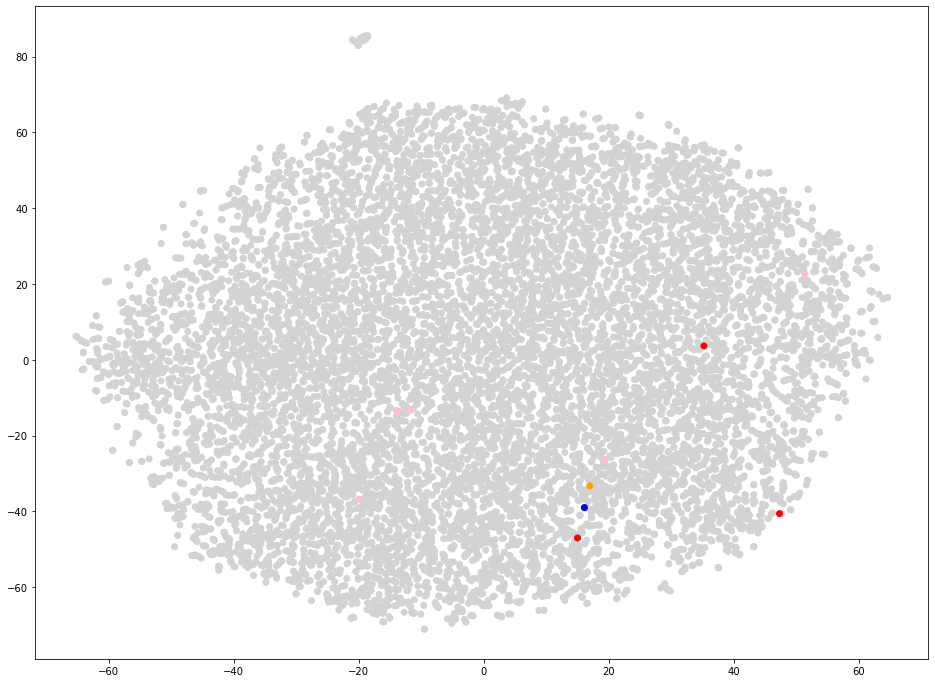

In [32]:
plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_w2v[:,0], tsne_embedded_w2v[:,1], color=COLORS)

### Vizualisation of the NN groups

In [33]:
COLORS_NN_GROUPS = ['blue', 'red', 'black', 'green', 'violet', 'pink', 'turquoise', 'gold', 'sienna', 'orange']

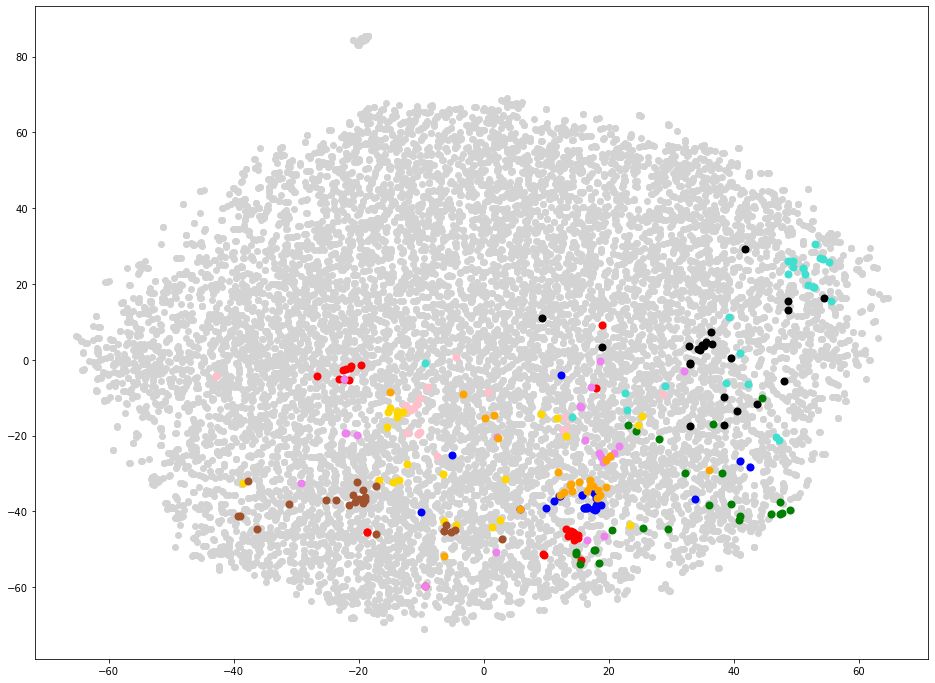

In [34]:
plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_w2v[:,0], tsne_embedded_w2v[:,1], color='lightgrey')
for color, i in zip(COLORS_NN_GROUPS, indices):
    plt.scatter(tsne_embedded_w2v[i, 0], tsne_embedded_w2v[i, 1], color=color, lw=2)

In [37]:
### Save results for validation

results = pd.DataFrame(columns=['original_question', 'article_title', 'abstract', 
                                'question_number', 'isRelevant', 'disease_on_abstract',
                                'chemicals_on_abstract','tsne_0', 'tsne_1'])
for i in range(len(indices)):
    for j in range(len(indices[i])):
        if j == 0:
            original_question = True
        else:
            original_question = False
        results.loc[len(results)] = [original_question, 
                                     df['title'][indices[i][j]],
                                     df['abstract'][indices[i][j]],
                                     'question_' + str(i+1), 
                                     '',
                                     df['disease_on_abstract'][indices[i][j]],
                                     df['chemicals_on_abstract'][indices[i][j]],
                                     tsne_embedded_w2v[:,0][indices[i][j]],
                                     tsne_embedded_w2v[:,1][indices[i][j]]
                                     ]
        
results.to_csv('results_NN_25_w2v_covid.csv')

### With Biomed RoBERTa

In [38]:
tokenizer = AutoTokenizer.from_pretrained("allenai/biomed_roberta_base")
biomed_roberta_model = AutoModel.from_pretrained("allenai/biomed_roberta_base")

In [39]:
articles_biomed_roberta_emb = []
start = time.time()

for i in range(len(df)):
    if i%1000 == 0:
        print(i)
    articles_biomed_roberta_emb.append(get_embeddings_hf(df['title'][i], biomed_roberta_model))

end = time.time()
print(end - start)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
2053.448917865753


In [40]:
# Save the vectors because it is long to run (~30min)

df['roberta_title_vectors'] = articles_biomed_roberta_emb

df.to_csv('../data/metadata_with_title_roberta_vectors.csv')

In [41]:
# # Take back the vectors

# df_temp = pd.read_csv('../data/metadata_with_title_roberta_vectors.csv')
# articles_biomed_roberta_emb = df_temp['roberta_title_vectors'].values

# articles_biomed_roberta_emb = [ast.literal_eval(a) for a in articles_biomed_roberta_emb]

In [42]:
nbrs_2 = NearestNeighbors(n_neighbors=25, algorithm='ball_tree').fit(articles_biomed_roberta_emb)

In [43]:
distances_2, indices_2 = nbrs_2.kneighbors(articles_biomed_roberta_emb[-10:])

In [44]:
df['title'][indices_2[QUESTION_NUMBER]].values

array(['Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.',
       'Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]',
       'Virus receptors: implications for pathogenesis and the design of antiviral agents.',
       'Recent insights into the development of therapeutics against coronavirus diseases by targeting N protein',
       'Targeting endosomal acidification by chloroquine analogs as a promising strategy for the treatment of emerging viral diseases',
       'Biochemical principles and inhibitors to interfere with viral capping pathways',
       'Rapid discovery and optimization of therapeutic antibodies against emerging infectious diseases',
       'Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclineth

### Vizulisation of the space with PCA + T-SNE of RoBERTa

In [45]:
pca = PCA(n_components=200)
principal_components_roberta = pca.fit_transform(articles_biomed_roberta_emb)

In [46]:
np.sum(pca.explained_variance_ratio_)

0.9349866317039737

In [47]:
tsne_embedded_roberta = TSNE(n_components=2).fit_transform(principal_components_roberta)

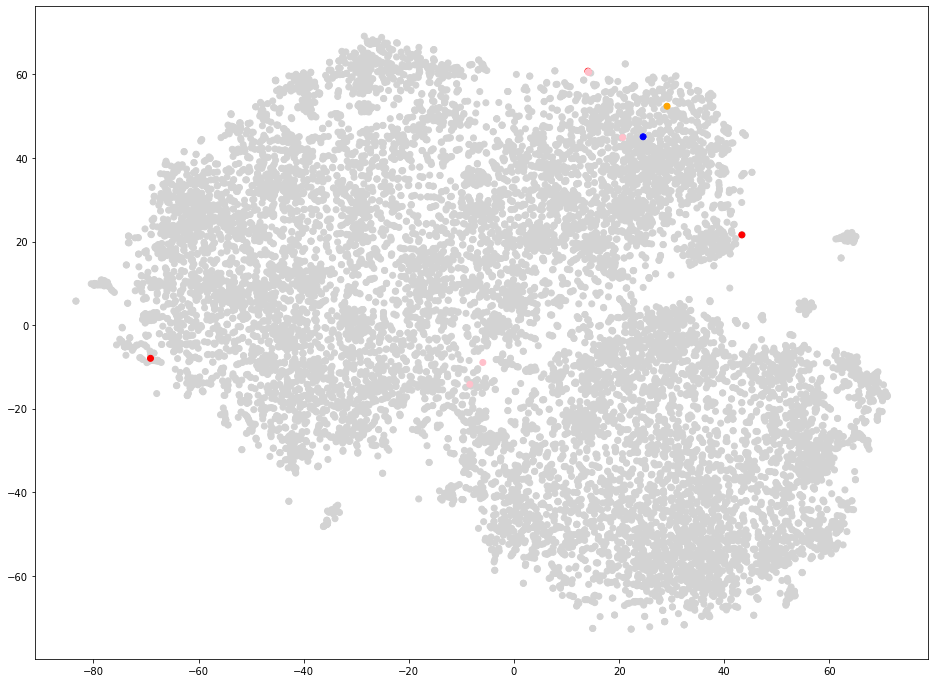

In [48]:
plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_roberta[:,0], tsne_embedded_roberta[:,1], color=COLORS)

### Vizualisation of the NN groups

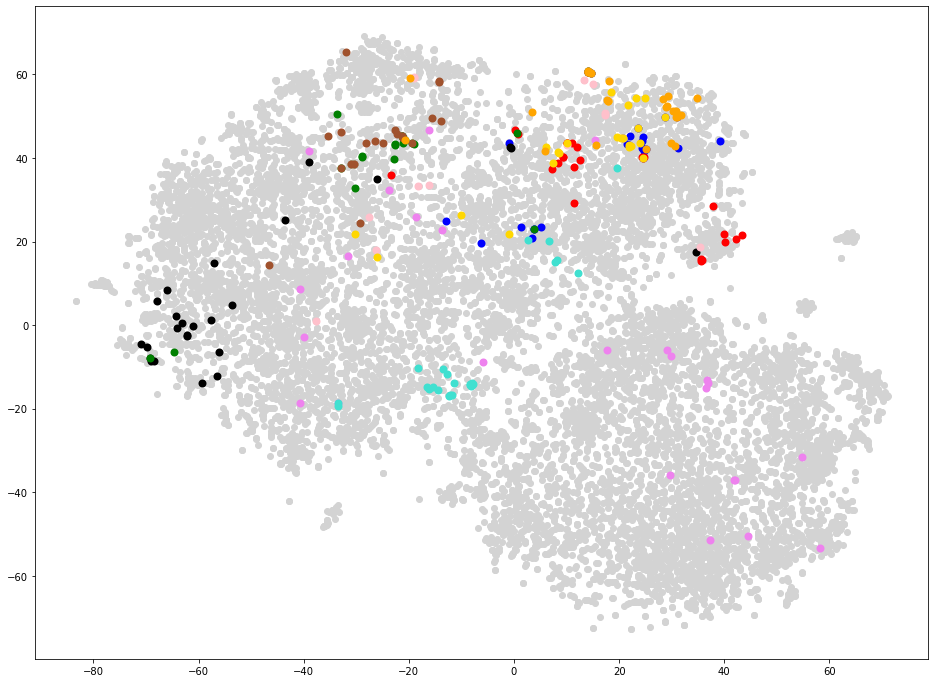

In [49]:
plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_roberta[:,0], tsne_embedded_roberta[:,1], color='lightgrey')
for color, i in zip(COLORS_NN_GROUPS, indices_2):
    plt.scatter(tsne_embedded_roberta[i, 0], tsne_embedded_roberta[i, 1], color=color, lw=2)

In [50]:
results = pd.DataFrame(columns=['original_question', 'article_title', 'abstract', 
                                'question_number', 'isRelevant', 'disease_on_abstract',
                                'chemicals_on_abstract', 'tsne_0', 'tsne_1'])
for i in range(len(indices_2)):
    for j in range(len(indices_2[i])):
        if j == 0:
            original_question = True
        else:
            original_question = False
        results.loc[len(results)] = [original_question, 
                                     df['title'][indices_2[i][j]],
                                     df['abstract'][indices_2[i][j]],
                                     'question_' + str(i+1), 
                                     '',
                                     df['disease_on_abstract'][indices_2[i][j]],
                                     df['chemicals_on_abstract'][indices_2[i][j]],
                                     tsne_embedded_roberta[:,0][indices_2[i][j]],
                                     tsne_embedded_roberta[:,1][indices_2[i][j]]
                                     ]

### With GPT-2 Covid (Computing is too heavy)

In [51]:
# from transformers import AutoModelWithLMHead

# tokenizer = AutoTokenizer.from_pretrained("mrm8488/GPT-2-finetuned-covid-bio-medrxiv")
# gpt_2 = AutoModelWithLMHead.from_pretrained("mrm8488/GPT-2-finetuned-covid-bio-medrxiv")

In [52]:
# articles_biomed_gpt_2_emb = []
# start = time.time()

# for i in range(len(df)):
#     if i%1000 == 0:
#         print(i)
#     articles_biomed_gpt_2_emb.append(get_embeddings_hf(df['title'][i], gpt_2))

# end = time.time()
# print(end - start)

In [53]:
# # Save the vectors because it is long to run (~50min)

# df['gpt_2_title_vectors'] = articles_biomed_gpt_2_emb

# df.to_csv('../data/metadata_with_title_gpt_2_vectors_titles.csv')

In [54]:
# # Take back the vectors

# df_temp = pd.read_csv('../data/metadata_with_title_gpt_2_vectors_titles.csv')
# articles_biomed_gpt_2_emb = df_temp['gpt_2_title_vectors'].values

# articles_biomed_gpt_2_emb = [ast.literal_eval(a) for a in articles_biomed_gpt_2_emb]

In [55]:
# nbrs_3 = NearestNeighbors(n_neighbors=25, algorithm='ball_tree').fit(articles_biomed_gpt_2_emb)

In [56]:
# distances_3, indices_3 = nbrs_3.kneighbors(articles_biomed_gpt_2_emb[-10:])

In [57]:
# df['title'][indices_3[QUESTION_NUMBER]].values

In [58]:
# ### Save results for validation

# results = pd.DataFrame(columns=['original_question', 'article_title', 'abstract', 'question_number', 
#                                 'isRelevant'])
# for i in range(len(indices_3)):
#     for j in range(len(indices_3[i])):
#         if j == 0:
#             original_question = True
#         else:
#             original_question = False
#         results.loc[len(results)] = [original_question, df['title'][indices_3[i][j]], 
#                                      df['abstract'], [indices_3[i][j]]'question_' + str(i+1), '']
        
# results.to_csv('results_NN_25_gpt_2_covid_title.csv')

In [59]:
### Vizulisation of the space with PCA + T-SNE of GPT-2 CoVid

In [60]:
# articles_biomed_gpt_2_emb[0]

In [61]:
# pca = PCA(n_components=200)
# principal_components_gpt_2 = pca.fit_transform(articles_biomed_gpt_2_emb)

In [62]:
# np.sum(pca.explained_variance_ratio_)

In [63]:
# tsne_embedded_gpt_2 = TSNE(n_components=2).fit_transform(principal_components_gpt_2)

In [64]:
# plt.figure(figsize=(16, 12))
# plt.scatter(tsne_embedded_gpt_2[:,0], tsne_embedded_gpt_2[:,1], color=COLORS)

In [65]:
### Vizualisation of the NN groups

In [66]:
# plt.figure(figsize=(16, 12))
# plt.scatter(tsne_embedded_gpt_2[:,0], tsne_embedded_gpt_2[:,1], color='lightgrey')
# for color, i in zip(COLORS_NN_GROUPS, indices_2):
#     plt.scatter(tsne_embedded_gpt_2[i, 0], tsne_embedded_gpt_2[i, 1], color=color, lw=2)

### Validation

We choose 25 articles, it is really arbitrary.  
By choosing a clustering method it can be more accurate.

Let's check the results dataframe one by one with a majority vote.  
Minus: No domain expert

### Results analysis

Coming soon ...

### Using a clustering Algo on RoBERTa vectors

### K-Means

In [67]:
kmeans = KMeans(n_clusters=20, random_state=42).fit(articles_biomed_roberta_emb)

In [68]:
clusters_questions = kmeans.labels_[-10:]
clusters_questions

array([12,  1,  4, 15, 17, 15, 19, 12, 15, 12], dtype=int32)

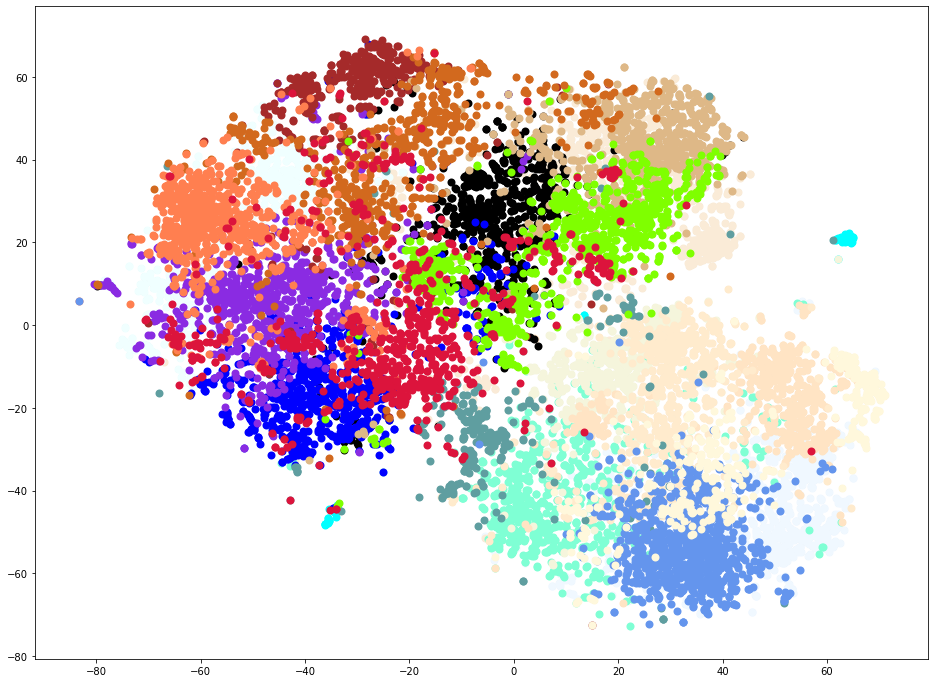

In [69]:
color_map = cm.get_cmap('tab20', kmeans.n_clusters)
all_colors = list(mcolors.CSS4_COLORS.keys())

plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_roberta[:,0], tsne_embedded_roberta[:,1], color='lightgrey')
for i in range(kmeans.n_clusters):
    mask = np.where(kmeans.labels_ == i)[0]
    plt.scatter(tsne_embedded_roberta[mask, 0], tsne_embedded_roberta[mask, 1], color=all_colors[i], lw=2)

In [71]:
## Save results for validation

results = df[['cord_uid', 'title', 'license', 'abstract',
       'publish_time', 'authors', 'journal', 'url', 'disease_on_abstract',
       'chemicals_on_abstract']]

results['cluster'] = kmeans.labels_
        
results.to_csv('results_k_means_20_roberta_title.csv')

/Users/samuel/anaconda/envs/venv_zencity_ai/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### DBSCAN

#### Estimate the eps for DBSCAN with the knn distance plot

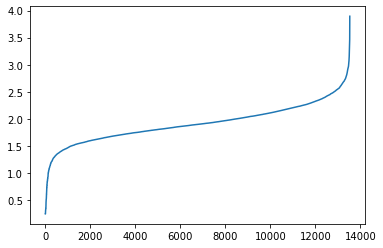

In [72]:
neigh = NearestNeighbors(n_neighbors=3, algorithm='auto')
nbrs = neigh.fit(articles_biomed_roberta_emb)
distances_dbscan, indices = nbrs.kneighbors(articles_biomed_roberta_emb)
distances_ordered = np.sort(distances_dbscan, axis=0)
plt.plot(distances_ordered[:,1])

In [73]:
dbscan = DBSCAN(eps=1.9, min_samples=3).fit(articles_biomed_roberta_emb)
clusters = dbscan.labels_

In [74]:
clusters_questions = clusters[-10:]
clusters_questions

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [75]:
len(set(clusters))

74

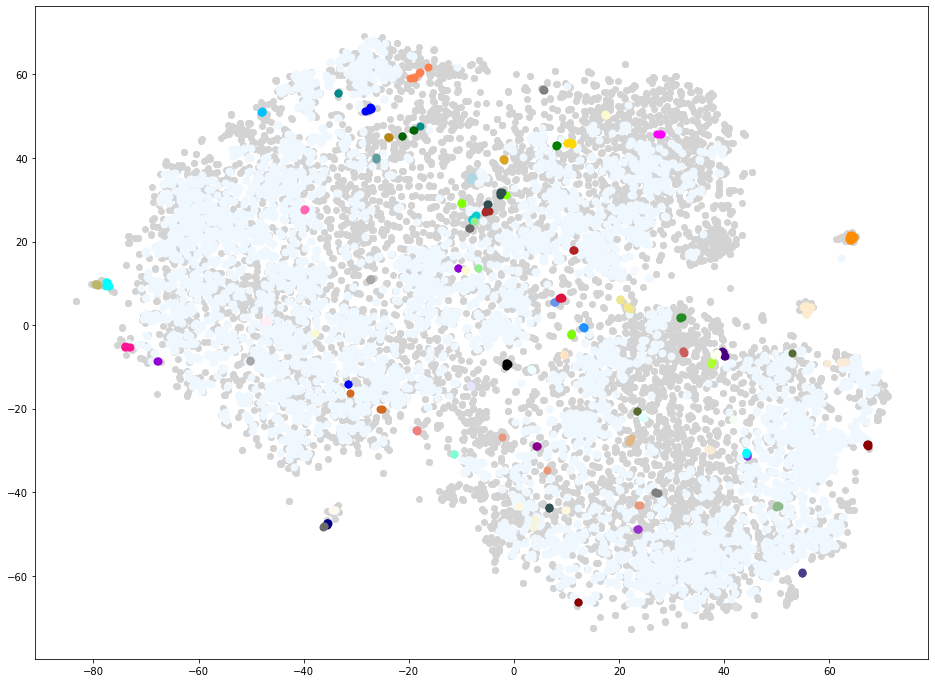

In [76]:
color_map = cm.get_cmap('tab20', len(set(clusters)))
all_colors = list(mcolors.CSS4_COLORS.keys())

plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_roberta[:,0], tsne_embedded_roberta[:,1], color='lightgrey')
for i in range(len(set(clusters))):
    mask = np.where(dbscan.labels_ == i)[0]
    plt.scatter(tsne_embedded_roberta[mask, 0], tsne_embedded_roberta[mask, 1], color=all_colors[i], lw=2)

### OPTICS

In [79]:
clustering = OPTICS(min_samples=3).fit(articles_biomed_roberta_emb)

In [ ]:
clusters = clustering.labels_
clusters_questions = clusters[-10:]
clusters_questions

In [ ]:
len(set(clusters))

In [ ]:
color_map = cm.get_cmap('tab20', len(set(clusters)))
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())

plt.figure(figsize=(16, 12))
plt.scatter(tsne_embedded_roberta[:,0], tsne_embedded_roberta[:,1], color='lightgrey')
for i in range(len(set(clusters))):
    mask = np.where(dbscan.labels_ == i)[0]
    plt.scatter(tsne_embedded_roberta[mask, 0], tsne_embedded_roberta[mask, 1], color=all_colors[i], lw=2)